### Load Full dataset and Pre,During and Post MCR + and - values

In [156]:
import pandas as pd


df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\BA_Featured_MCR.csv")
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_pre.csv")  
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_BA_mcr_df_during.csv") 
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_post.csv")  

print("Shapes:", df_features.shape, df_pre.shape, df_during.shape, df_post.shape)
display(df_features.head(3))
display(df_pre.head(3))
display(df_during.head(3))
display(df_post.head(3))

Shapes: (3217, 46) (29, 3) (29, 3) (29, 3)


,overall_rating,review_date,verified_flag,travel_class,seat_comfort,staff_service,ground_service,value_for_money,recommended,food_quality,...,travel_type_missing,type_Business,type_Couple,type_Family,type_Solo,type_Unknown,food_quality_missing,wifi_missing,entertainment_missing,ground_service_missing
0,1.0,2023-11-19,2,1,1,1,1.0,1,0,2.0,...,0,False,True,False,False,False,1,1,1,0
1,3.0,2023-11-19,2,1,2,3,1.0,2,0,1.0,...,0,True,False,False,False,False,0,0,0,0
2,8.0,2023-11-16,1,3,3,3,4.0,3,1,4.0,...,0,False,True,False,False,False,0,1,1,0


,variable,MCR-,MCR+
0,verified_flag,0.012539,0.016681
1,travel_class,0.030393,0.038999
2,seat_comfort,1.258806,1.360692


,variable,MCR-,MCR+
0,verified_flag,0.010384,0.024887
1,travel_class,0.013638,0.029727
2,seat_comfort,0.449197,0.786237


,variable,MCR-,MCR+
0,verified_flag,0.000000,0.905139
1,travel_class,0.000000,1.797859
2,seat_comfort,0.068523,7.883940


### Standardizing MCR Column Names  
- Ensures consistent column labels across pre-, during-, and post-COVID datasets.  
- Renames feature identifiers to `variable`.  
- Aligns MCR values to `MCR-` (lower bound) and `MCR+` (upper bound).  
- Prepares the datasets for merging and comparison.  

In [157]:
def standardize_mcr_cols(df):
    rename = {}
    for c in df.columns:
        cl = c.strip().lower()
        if "feature" in cl or "variable" in cl or "name" in cl:
            rename[c] = "variable"
        elif "mcr" in cl and ("-" in cl or "min" in cl or "lower" in cl):
            rename[c] = "MCR-"
        elif "mcr" in cl and ("+" in cl or "max" in cl or "upper" in cl):
            rename[c] = "MCR+"
    return df.rename(columns=rename)

df_pre    = standardize_mcr_cols(df_pre)
df_during = standardize_mcr_cols(df_during)
df_post   = standardize_mcr_cols(df_post)

print("Standardized columns:")
print("pre   :", df_pre.columns.tolist())
print("during:", df_during.columns.tolist())
print("post  :", df_post.columns.tolist())

Standardized columns:
pre   : ['variable', 'MCR-', 'MCR+']
during: ['variable', 'MCR-', 'MCR+']
post  : ['variable', 'MCR-', 'MCR+']


This code identifies the features whose **maximum importance (MCR⁺) changed the most across pre-, during-, and post-COVID**, quantifies that drift, and shows how their importance ranks shifted over time.

### Merging Periods and Computing Drift Metrics
Combined pre-, during-, and post-COVID MCR datasets into a single dataframe.  

In [158]:
import pandas as pd

# Load your dataset
df_features = pd.read_csv(BASE / f_features)

# Convert review_date to datetime
df_features["review_date"] = pd.to_datetime(df_features["review_date"])

# Function to tag covid period
def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

# Apply covid period labeling
df_features["covid_period"] = df_features["review_date"].apply(assign_covid_period)

# Split into subsets
df_pre_data = df_features[df_features["covid_period"] == "pre"]
df_during_data = df_features[df_features["covid_period"] == "during"]
df_post_data = df_features[df_features["covid_period"] == "post"]

# Quick sanity check
print("All data:", df_features.shape)
print("Pre-COVID:", df_pre_data.shape)
print("During COVID:", df_during_data.shape)
print("Post-COVID:", df_post_data.shape)

All data: (3217, 47)
Pre-COVID: (2559, 47)
During COVID: (191, 47)
Post-COVID: (467, 47)


### Combining Periods and Identifying Top Drifting Features  
- Merged pre-, during-, and post-COVID MCR datasets into a single table.  
- Calculated drift magnitudes:  
  - `pre → during`  
  - `during → post`  
  - `total drift` across periods.  
- Assigned feature ranks within each period based on `MCR+` values.   
- Extracted top 10 features with the largest overall drift for closer inspection.  

In [137]:
import pandas as pd
import numpy as np

# Start from your df_pre/df_during/df_post already loaded and standardized
ba_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# Drift magnitudes (you can also compute using MCR- analogously)
ba_all["drift_pre_dur"]  = (ba_all["MCR+_dur"]  - ba_all["MCR+_pre"]).abs()
ba_all["drift_dur_post"] = (ba_all["MCR+_post"] - ba_all["MCR+_dur"]).abs()
ba_all["total_drift"]    = ba_all["drift_pre_dur"] + ba_all["drift_dur_post"]

# Period-wise ranks (1 = most important). Ties='dense' keeps integers.
ba_all["rank_pre"]  = ba_all["MCR+_pre"].rank(ascending=False, method="dense")
ba_all["rank_dur"]  = ba_all["MCR+_dur"].rank(ascending=False, method="dense")
ba_all["rank_post"] = ba_all["MCR+_post"].rank(ascending=False, method="dense")

# Rank changes (positive = moved DOWN in importance; negative = moved UP)
ba_all["rank_change_pre_to_dur"]  = ba_all["rank_dur"]  - ba_all["rank_pre"]
ba_all["rank_change_dur_to_post"] = ba_all["rank_post"] - ba_all["rank_dur"]

# Top drifting features
top_drift = ba_all.sort_values("total_drift", ascending=False).head(10)
top_drift[["variable","MCR+_pre","MCR+_dur","MCR+_post","total_drift","rank_pre","rank_dur","rank_post"]]

,variable,MCR+_pre,MCR+_dur,MCR+_post,total_drift,rank_pre,rank_dur,rank_post
4,ground_service,0.668522,1.036486,9.606638,8.938116,6.0,3.0,1.0
20,topic_refunds_lounge,0.175955,0.250125,8.962741,8.786785,11.0,11.0,2.0
5,food_quality,1.063328,0.340700,7.866381,8.248308,2.0,8.0,6.0
2,seat_comfort,1.360692,0.786237,7.883940,7.672159,1.0,4.0,5.0
11,staff_sentiment,0.715276,1.618342,8.245396,7.530120,5.0,1.0,3.0
9,food_sentiment,0.749901,1.047059,7.960385,7.210484,4.0,2.0,4.0
19,topic_staff_customer_seating,0.102668,0.189293,6.220343,6.117675,17.0,14.0,8.0
3,staff_service,0.910043,0.778959,6.443255,5.795379,3.0,5.0,7.0
14,lounge_sentiment,0.232595,0.271813,5.929979,5.697383,9.0,10.0,9.0
22,topic_meals_food,0.130174,0.076363,5.555246,5.532694,14.0,17.0,10.0


Top 10 Rankedked (based on MCR+) per period

### Ranking and Selecting Top Features by Period  

In [53]:
# Rank features within each period
df_pre["rank_pre"]      = df_pre["MCR+"].rank(ascending=False, method="dense")
df_during["rank_during"]= df_during["MCR+"].rank(ascending=False, method="dense")
df_post["rank_post"]    = df_post["MCR+"].rank(ascending=False, method="dense")

# Sort and select Top 10 per period
top_pre    = df_pre.sort_values("rank_pre").head(10)[["variable","MCR+","rank_pre"]]
top_during = df_during.sort_values("rank_during").head(10)[["variable","MCR+","rank_during"]]
top_post   = df_post.sort_values("rank_post").head(10)[["variable","MCR+","rank_post"]]

print("=== Top 10 Pre-COVID ===")
display(top_pre)

print("=== Top 10 During-COVID ===")
display(top_during)

print("=== Top 10 Post-COVID ===")
display(top_post)

=== Top 10 Pre-COVID ===


,variable,MCR+,rank_pre
2,seat_comfort,1.360692,1.0
5,food_quality,1.063328,2.0
3,staff_service,0.910043,3.0
9,food_sentiment,0.749901,4.0
11,staff_sentiment,0.715276,5.0
4,ground_service,0.668522,6.0
10,seat_sentiment,0.406106,7.0
17,airport_service_sentiment,0.265871,8.0
14,lounge_sentiment,0.232595,9.0
13,refunds_sentiment,0.220030,10.0


=== Top 10 During-COVID ===


,variable,MCR+,rank_during
11,staff_sentiment,1.618342,1.0
9,food_sentiment,1.047059,2.0
4,ground_service,1.036486,3.0
2,seat_comfort,0.786237,4.0
3,staff_service,0.778959,5.0
13,refunds_sentiment,0.481158,6.0
21,topic_business_experience,0.390582,7.0
5,food_quality,0.340700,8.0
17,airport_service_sentiment,0.328409,9.0
14,lounge_sentiment,0.271813,10.0


=== Top 10 Post-COVID ===


,variable,MCR+,rank_post
4,ground_service,9.606638,1.0
20,topic_refunds_lounge,8.962741,2.0
11,staff_sentiment,8.245396,3.0
9,food_sentiment,7.960385,4.0
2,seat_comfort,7.883940,5.0
5,food_quality,7.866381,6.0
3,staff_service,6.443255,7.0
19,topic_staff_customer_seating,6.220343,8.0
14,lounge_sentiment,5.929979,9.0
22,topic_meals_food,5.555246,10.0


It merges pre-, during-, and post-COVID MCR values, then computes  
1. **Drift magnitude (Δᵢ):** total absolute change in MCR⁺ across periods,  
2. **Volatility (Vᵢ):** maximum spread between MCR⁻ and MCR⁺ (uncertainty in reliance),  
3. **Rank drift (Rᵢ):** largest shift in importance ranking across periods, and  
4. **Concept Drift Index (CDI):** the system-wide average drift across all features,  
finally listing the top 10 most drifting features with their scores.  


### Computing Drift and Concept Drift Index (CDI)  

- **Merged pre-, during-, and post-COVID MCR values** into a single table for feature-level comparison.  
- Calculated multiple drift indicators:  
  1. **Drift Magnitude (Δᵢ):** Absolute total change in `MCR+` across periods.  
  2. **Volatility Index (Vᵢ):** Maximum width of the feature’s reliance interval `[MCR−, MCR+]` across periods.  
  3. **Rank Drift (Rᵢ):** Maximum change in feature importance rank across periods.  
- Derived a **system-level Concept Drift Index (CDI):** the mean drift magnitude across all features, summarizing overall drift intensity.  
- Identified the **Top 10 features with the highest drift** for closer inspection.  

In [54]:
import pandas as pd

# Merge all periods into one table
ba_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# --------------------
# 1. Drift Magnitude Δ_i
# --------------------
ba_all["drift_total"] = (
    (ba_all["MCR+_pre"] - ba_all["MCR+_dur"]).abs()
    + (ba_all["MCR+_dur"] - ba_all["MCR+_post"]).abs()
)

# --------------------
# 2. Volatility Index V_i (max width of [MCR-, MCR+])
# --------------------
ba_all["range_pre"]  = ba_all["MCR+_pre"]  - ba_all["MCR-_pre"]
ba_all["range_dur"]  = ba_all["MCR+_dur"]  - ba_all["MCR-_dur"]
ba_all["range_post"] = ba_all["MCR+_post"] - ba_all["MCR-_post"]
ba_all["volatility"] = ba_all[["range_pre","range_dur","range_post"]].max(axis=1)

# --------------------
# 3. Rank Drift R_i
# --------------------
ba_all["rank_pre"]  = ba_all["MCR+_pre"].rank(ascending=False, method="dense")
ba_all["rank_dur"]  = ba_all["MCR+_dur"].rank(ascending=False, method="dense")
ba_all["rank_post"] = ba_all["MCR+_post"].rank(ascending=False, method="dense")

ba_all["rank_drift"] = ba_all.apply(
    lambda row: max(abs(row["rank_pre"]-row["rank_dur"]),
                    abs(row["rank_dur"]-row["rank_post"])),
    axis=1
)

# --------------------
# 4. System-Level Concept Drift Index (CDI)
# --------------------
CDI = ba_all["drift_total"].mean()

print(f"Concept Drift Index (CDI) for BA = {CDI:.3f}")

# --------------------
# Show top drifting features
# --------------------
top_drift = ba_all.sort_values("drift_total", ascending=False)[
    ["variable","MCR+_pre","MCR+_dur","MCR+_post","drift_total","volatility","rank_pre","rank_dur","rank_post","rank_drift"]
].head(10)

display(top_drift)

Concept Drift Index (CDI) for BA = 4.286


,variable,MCR+_pre,MCR+_dur,MCR+_post,drift_total,volatility,rank_pre,rank_dur,rank_post,rank_drift
4,ground_service,0.668522,1.036486,9.606638,8.938116,9.514989,6.0,3.0,1.0,3.0
20,topic_refunds_lounge,0.175955,0.250125,8.962741,8.786785,8.891221,11.0,11.0,2.0,9.0
5,food_quality,1.063328,0.340700,7.866381,8.248308,7.854818,2.0,8.0,6.0,6.0
2,seat_comfort,1.360692,0.786237,7.883940,7.672159,7.815417,1.0,4.0,5.0,3.0
11,staff_sentiment,0.715276,1.618342,8.245396,7.530120,8.217131,5.0,1.0,3.0,4.0
9,food_sentiment,0.749901,1.047059,7.960385,7.210484,7.890150,4.0,2.0,4.0,2.0
19,topic_staff_customer_seating,0.102668,0.189293,6.220343,6.117675,6.216488,17.0,14.0,8.0,6.0
3,staff_service,0.910043,0.778959,6.443255,5.795379,6.413490,3.0,5.0,7.0,2.0
14,lounge_sentiment,0.232595,0.271813,5.929979,5.697383,5.890364,9.0,10.0,9.0,1.0
22,topic_meals_food,0.130174,0.076363,5.555246,5.532694,5.552891,14.0,17.0,10.0,7.0


# MCR top features per period

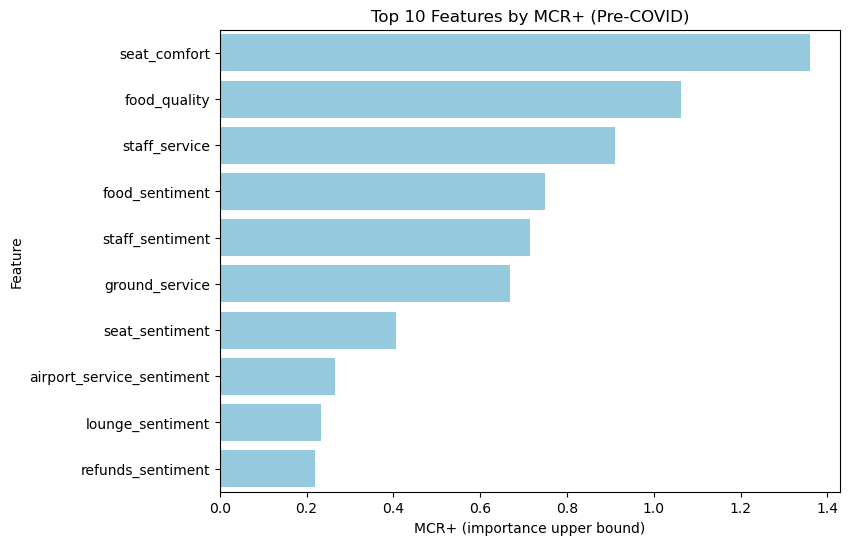

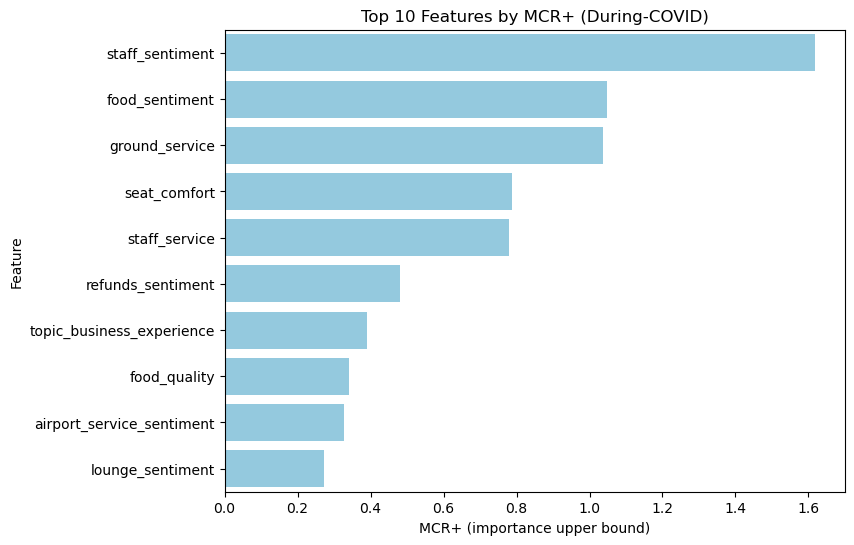

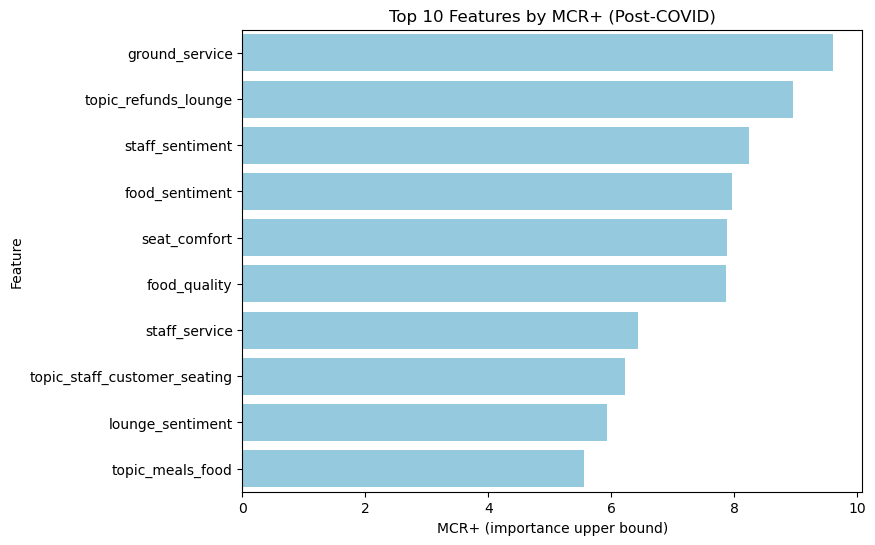

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# STEP 1: Importance per Period
# ======================
def plot_importance(df, mcr_col, rank_col, title):
    df_sorted = df.sort_values(rank_col).head(10)
    plt.figure(figsize=(8,6))
    sns.barplot(x=mcr_col, y="variable", data=df_sorted, color="skyblue")
    plt.title(f"Top 10 Features by {mcr_col} ({title})")
    plt.xlabel("MCR+ (importance upper bound)")
    plt.ylabel("Feature")
    plt.show()

plot_importance(df_pre, "MCR+", "rank_pre", "Pre-COVID")
plot_importance(df_during, "MCR+", "rank_during", "During-COVID")
plot_importance(df_post, "MCR+", "rank_post", "Post-COVID")

## Heatmap Ranking Across Periods

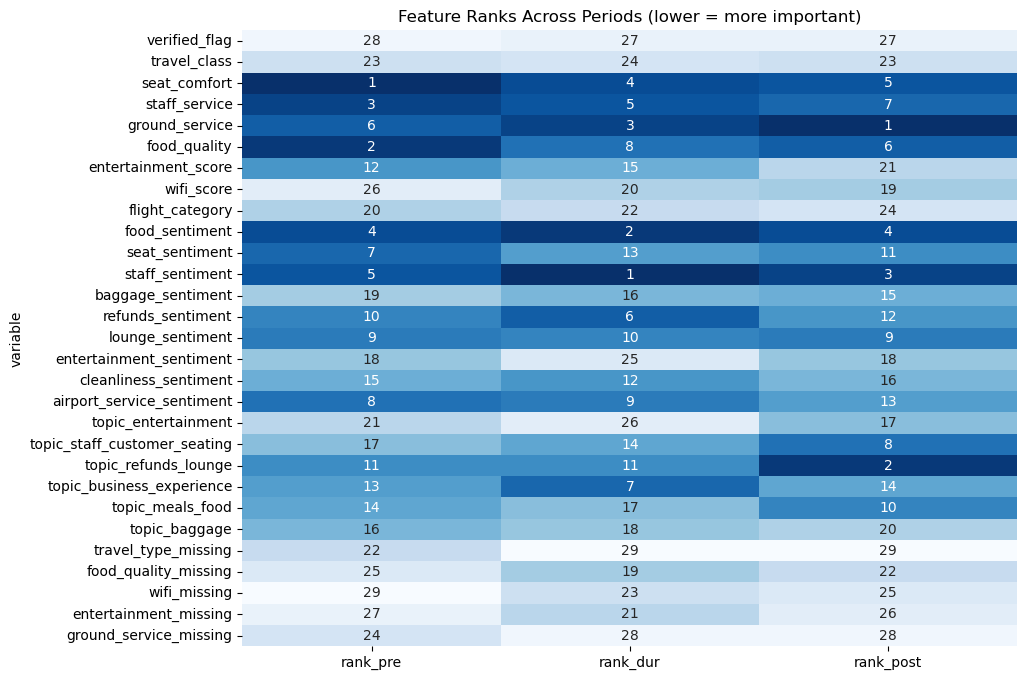

Concept Drift Index (CDI) for BA = 4.286


In [56]:
rank_table = (
    ba_all[["variable","rank_pre","rank_dur","rank_post"]]
    .set_index("variable")
)

plt.figure(figsize=(10,8))
sns.heatmap(rank_table, annot=True, cmap="Blues_r", cbar=False)
plt.title("Feature Ranks Across Periods (lower = more important)")
plt.show()

# ======================
# STEP 4: System-Level CDI
# ======================
CDI = ba_all["drift_total"].mean()
print(f"Concept Drift Index (CDI) for BA = {CDI:.3f}")

### Top 5 Feature Trajectory MCR+ values across periods

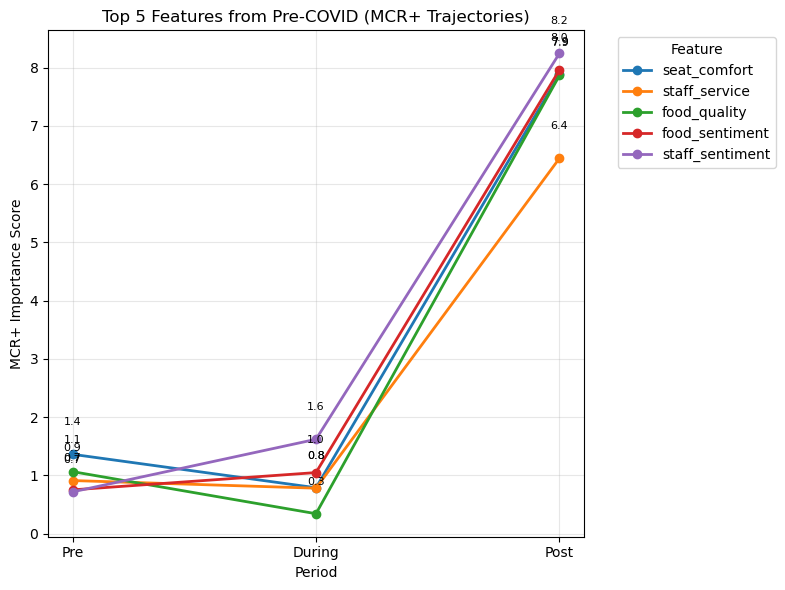

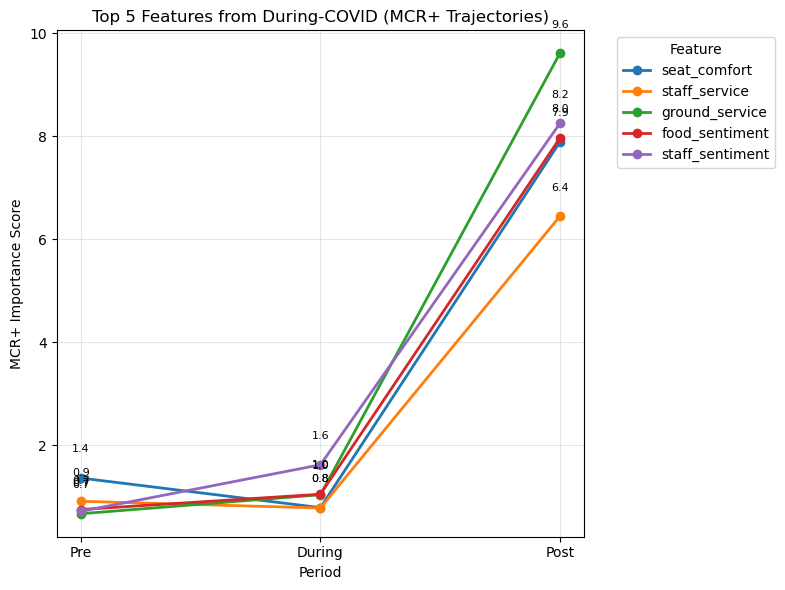

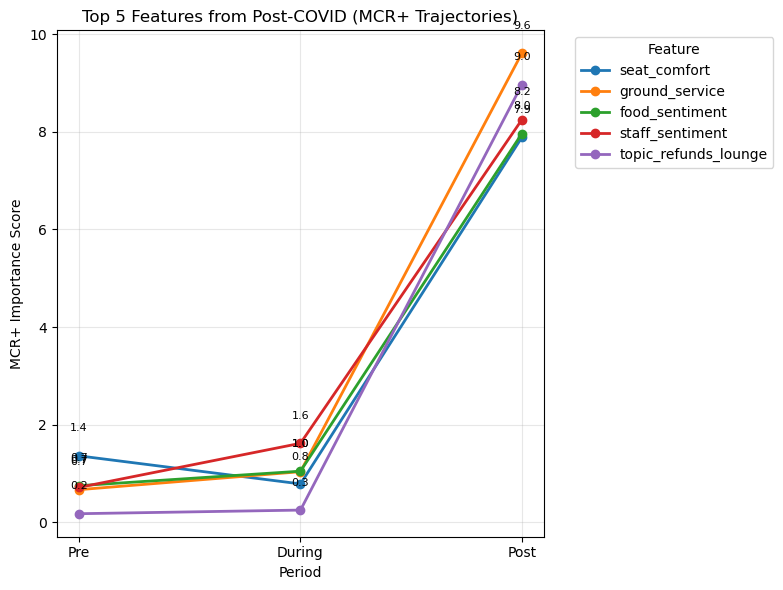

In [60]:
def plot_top5_trajectories(df_period, period_name, df_all):
    # Get top 5 features for this period
    top5 = df_period.nlargest(5, "MCR+")["variable"].tolist()
    subset = df_all[df_all["variable"].isin(top5)]

    # Plot
    plt.figure(figsize=(8,6))
    for _, row in subset.iterrows():
        ys = [row["MCR+_pre"], row["MCR+_dur"], row["MCR+_post"]]
        plt.plot(["Pre","During","Post"], ys, marker="o", linewidth=2, label=row["variable"])
        for i, val in enumerate(ys):
            plt.text(i, val+0.5, f"{val:.1f}", ha="center", fontsize=8)

    plt.title(f"Top 5 Features from {period_name} (MCR+ Trajectories)")
    plt.ylabel("MCR+ Importance Score")
    plt.xlabel("Period")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run for Pre, During, Post
plot_top5_trajectories(df_pre, "Pre-COVID", ba_all)
plot_top5_trajectories(df_during, "During-COVID", ba_all)
plot_top5_trajectories(df_post, "Post-COVID", ba_all)


### Top 5 Feature Trajectory MCR+ values across periods [Normalised]

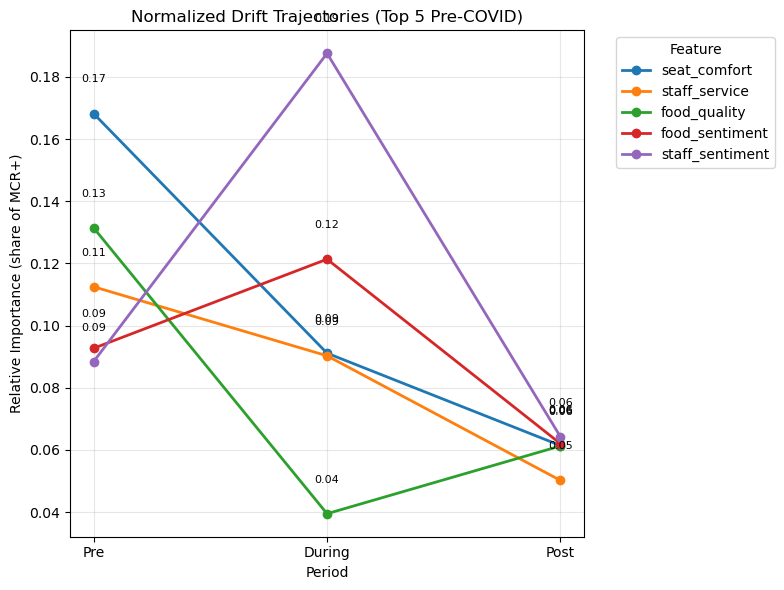

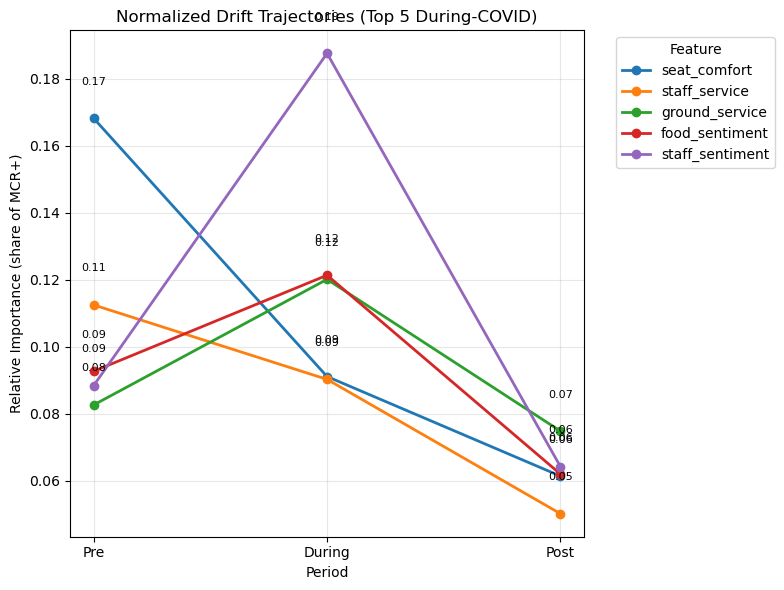

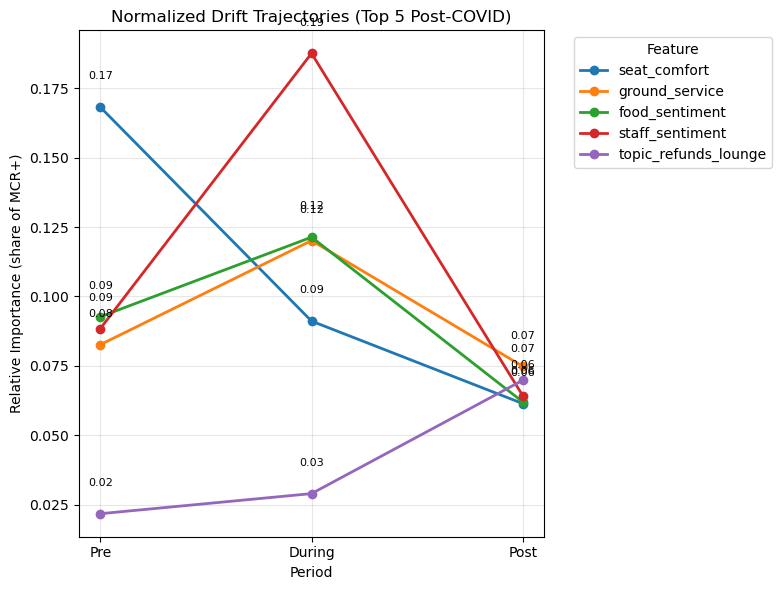

In [61]:
# Make a copy to avoid overwriting
ba_norm = ba_all.copy()

# Normalize MCR+ scores within each period
for col in ["MCR+_pre", "MCR+_dur", "MCR+_post"]:
    ba_norm[col] = ba_norm[col] / ba_norm[col].sum()

# === Plot normalized trajectories for top features per period ===
def plot_top5_norm(df_period, period_name, df_all):
    # Get top 5 features by raw MCR+ in this period
    top5 = df_period.nlargest(5, "MCR+")["variable"].tolist()
    subset = df_all[df_all["variable"].isin(top5)]

    # Plot
    plt.figure(figsize=(8,6))
    for _, row in subset.iterrows():
        ys = [row["MCR+_pre"], row["MCR+_dur"], row["MCR+_post"]]
        plt.plot(["Pre","During","Post"], ys, marker="o", linewidth=2, label=row["variable"])
        for i, val in enumerate(ys):
            plt.text(i, val+0.01, f"{val:.2f}", ha="center", fontsize=8)

    plt.title(f"Normalized Drift Trajectories (Top 5 {period_name})")
    plt.ylabel("Relative Importance (share of MCR+)")
    plt.xlabel("Period")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run for Pre, During, Post
plot_top5_norm(df_pre, "Pre-COVID", ba_norm)
plot_top5_norm(df_during, "During-COVID", ba_norm)
plot_top5_norm(df_post, "Post-COVID", ba_norm)

### Slope chart for Commparison of Ranks

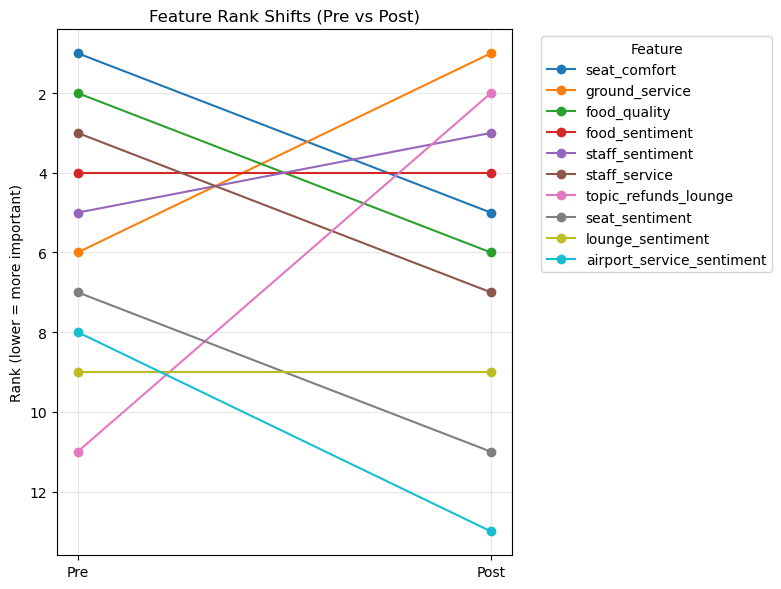

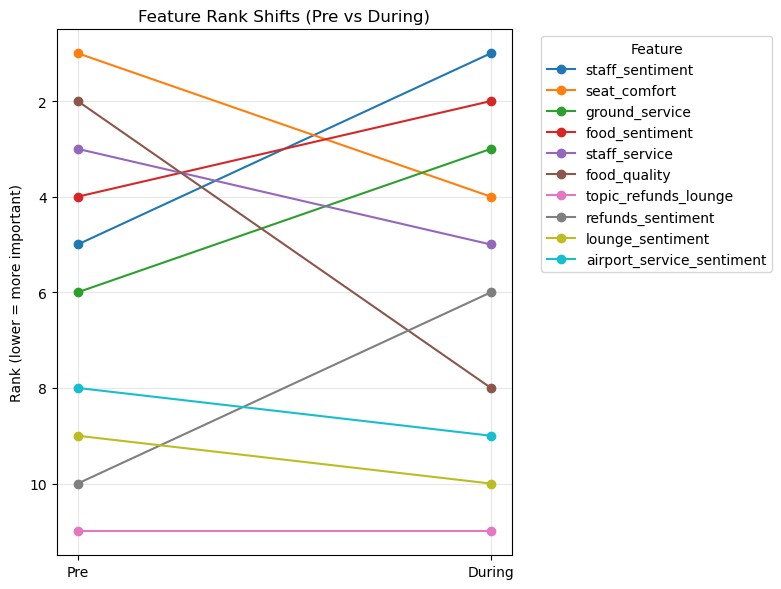

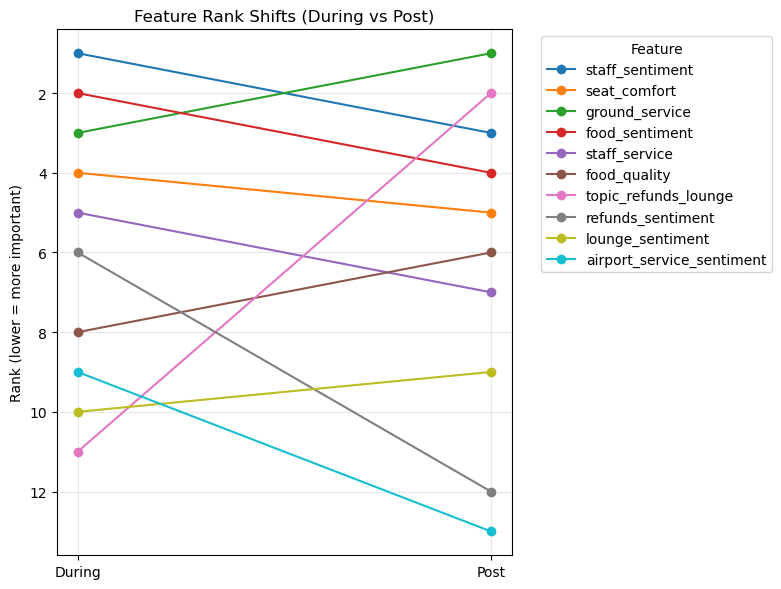

In [219]:
# Get top N (say 10) features by average rank
topN = ba_all.copy()
topN["avg_rank"] = topN[["rank_pre","rank_post"]].mean(axis=1)
topN = topN.nsmallest(10,"avg_rank")

# Create slope chart data
df_slope = topN.melt(id_vars="variable", value_vars=["rank_pre","rank_post"],
                     var_name="period", value_name="rank")

# Plot slope chart
plt.figure(figsize=(8,6))
for var in df_slope["variable"].unique():
    sub = df_slope[df_slope["variable"]==var]
    plt.plot(["Pre","Post"], sub["rank"], marker="o", label=var)

plt.gca().invert_yaxis()  # lower rank = more important
plt.title("Feature Rank Shifts (Pre vs Post)")
plt.ylabel("Rank (lower = more important)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# === Top N features by average rank (same logic) ===
topN = ba_all.copy()
topN["avg_rank"] = ba_all[["rank_pre","rank_dur","rank_post"]].mean(axis=1)
topN = topN.nsmallest(10,"avg_rank")


# === Pre vs During ===
df_slope_pre_dur = topN.melt(
    id_vars="variable", 
    value_vars=["rank_pre","rank_dur"],
    var_name="period", value_name="rank"
)

plt.figure(figsize=(8,6))
for var in df_slope_pre_dur["variable"].unique():
    sub = df_slope_pre_dur[df_slope_pre_dur["variable"]==var]
    plt.plot(["Pre","During"], sub["rank"], marker="o", label=var)

plt.gca().invert_yaxis()
plt.title("Feature Rank Shifts (Pre vs During)")
plt.ylabel("Rank (lower = more important)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === During vs Post ===
df_slope_dur_post = topN.melt(
    id_vars="variable", 
    value_vars=["rank_dur","rank_post"],
    var_name="period", value_name="rank"
)

plt.figure(figsize=(8,6))
for var in df_slope_dur_post["variable"].unique():
    sub = df_slope_dur_post[df_slope_dur_post["variable"]==var]
    plt.plot(["During","Post"], sub["rank"], marker="o", label=var)

plt.gca().invert_yaxis()
plt.title("Feature Rank Shifts (During vs Post)")
plt.ylabel("Rank (lower = more important)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


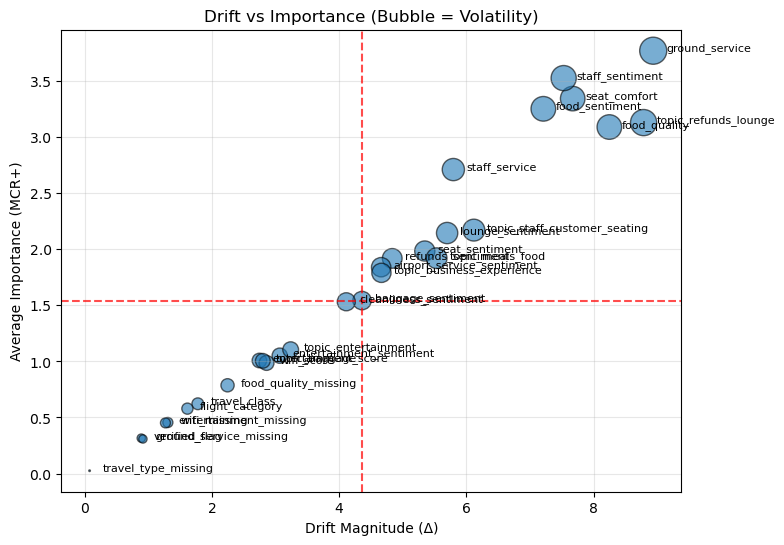

In [69]:
# Make sure avg_importance is created
ba_all["avg_importance"] = ba_all[["MCR+_pre", "MCR+_dur", "MCR+_post"]].mean(axis=1)

plt.figure(figsize=(8,6))

x = ba_all["drift_total"]
y = ba_all["avg_importance"]
s = ba_all["volatility"]*40  # bubble size

plt.scatter(x, y, s=s, alpha=0.6, edgecolor="k")

# Annotate features
for i,row in ba_all.iterrows():
    plt.text(row["drift_total"]+0.2, row["avg_importance"], row["variable"], fontsize=8)

# Add quadrant lines (using medians)
plt.axvline(x.median(), color="red", linestyle="--", alpha=0.7)
plt.axhline(y.median(), color="red", linestyle="--", alpha=0.7)

plt.xlabel("Drift Magnitude (Δ)")
plt.ylabel("Average Importance (MCR+)")
plt.title("Drift vs Importance (Bubble = Volatility)")
plt.grid(alpha=0.3)
plt.show()

### Radar Plot: Category-Level Drift in Feature Reliance  

- Grouped individual features into **three broad categories**:  
  - **Service** (e.g., seat comfort, staff service, wifi, food quality).  
  - **Sentiment** (e.g., sentiment scores across food, seat, staff, baggage, etc.).  
  - **Topics** (all topic_* variables).

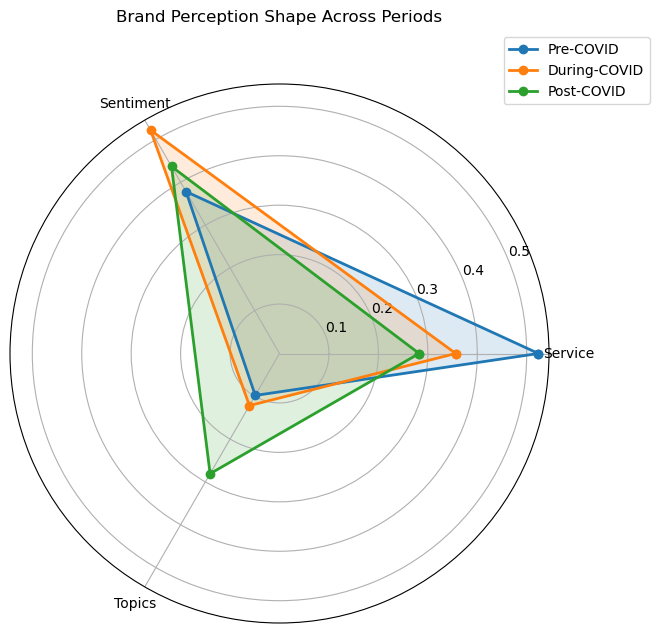

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Define categories
categories = {
    "Service": ["seat_comfort","staff_service","ground_service","value_for_money",
                "food_quality","entertainment","wifi"],
    "Sentiment": ["sentiment_score","food_sentiment","seat_sentiment","staff_sentiment",
                  "baggage_sentiment","refunds_sentiment","lounge_sentiment",
                  "entertainment_sentiment","cleanliness_sentiment","airport_service_sentiment"],
    "Topics": [c for c in ba_all["variable"] if c.startswith("topic_")]
}

# Function: aggregate importance by category (normalized)
def get_category_values(period_col):
    values = []
    for cat, feats in categories.items():
        vals = ba_all.loc[ba_all["variable"].isin(feats), period_col].sum()
        values.append(vals)
    # normalize to sum=1
    values = np.array(values) / np.sum(values)
    values = list(values) + [values[0]]  # close loop
    return values

# Labels & angles
labels = list(categories.keys())
angles = np.linspace(0, 2*np.pi, len(labels)+1, endpoint=True)

# Values for each period
vals_pre = get_category_values("MCR+_pre")
vals_dur = get_category_values("MCR+_dur")
vals_post = get_category_values("MCR+_post")

# Plot
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, vals_pre, "o-", linewidth=2, label="Pre-COVID")
ax.fill(angles, vals_pre, alpha=0.15)

ax.plot(angles, vals_dur, "o-", linewidth=2, label="During-COVID")
ax.fill(angles, vals_dur, alpha=0.15)

ax.plot(angles, vals_post, "o-", linewidth=2, label="Post-COVID")
ax.fill(angles, vals_post, alpha=0.15)

ax.set_thetagrids(angles[:-1]*180/np.pi, labels)
ax.set_title("Brand Perception Shape Across Periods", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.show()

## Structure of Reliance shifted categories over time Pie Chart

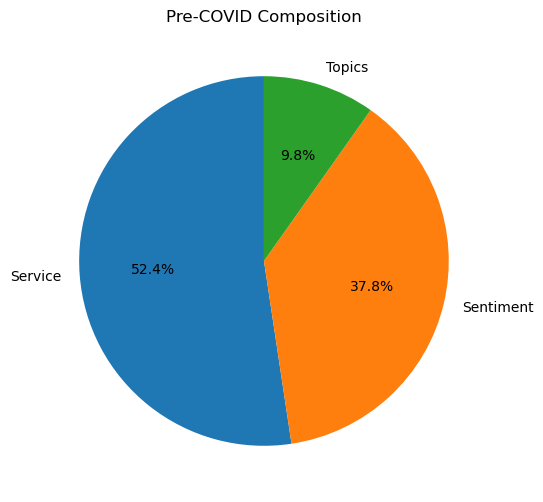

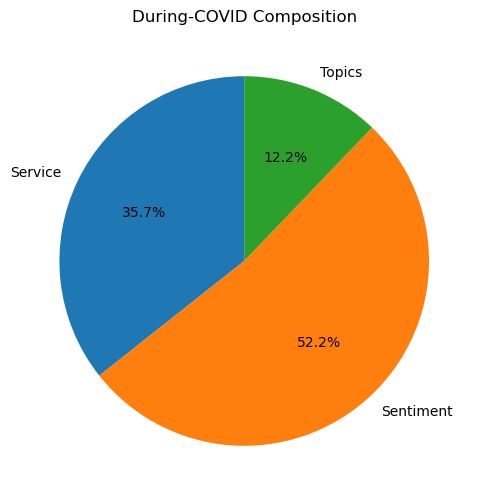

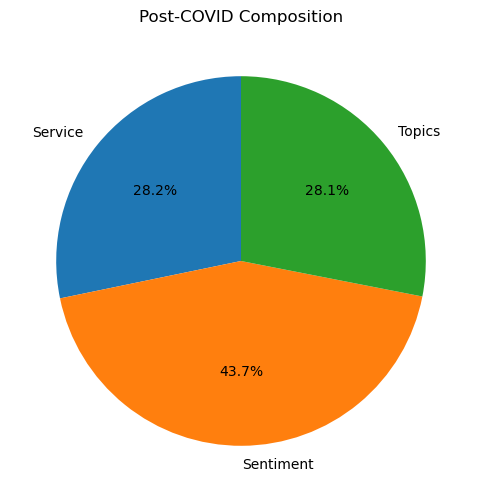

In [70]:
import matplotlib.pyplot as plt

# Define feature groups
categories = {
    "Service": ["seat_comfort","staff_service","ground_service","value_for_money",
                "food_quality","entertainment","wifi"],
    "Sentiment": ["sentiment_score","food_sentiment","seat_sentiment","staff_sentiment",
                  "baggage_sentiment","refunds_sentiment","lounge_sentiment",
                  "entertainment_sentiment","cleanliness_sentiment","airport_service_sentiment"],
    "Topics": [c for c in ba_all["variable"] if c.startswith("topic_")]
}

def pie_chart(period_col, title):
    data = []
    labels = []
    for cat, feats in categories.items():
        val = ba_all.loc[ba_all["variable"].isin(feats), period_col].sum()
        data.append(val)
        labels.append(cat)
    plt.figure(figsize=(6,6))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.show()

pie_chart("MCR+_pre", "Pre-COVID Composition")
pie_chart("MCR+_dur", "During-COVID Composition")
pie_chart("MCR+_post", "Post-COVID Composition")


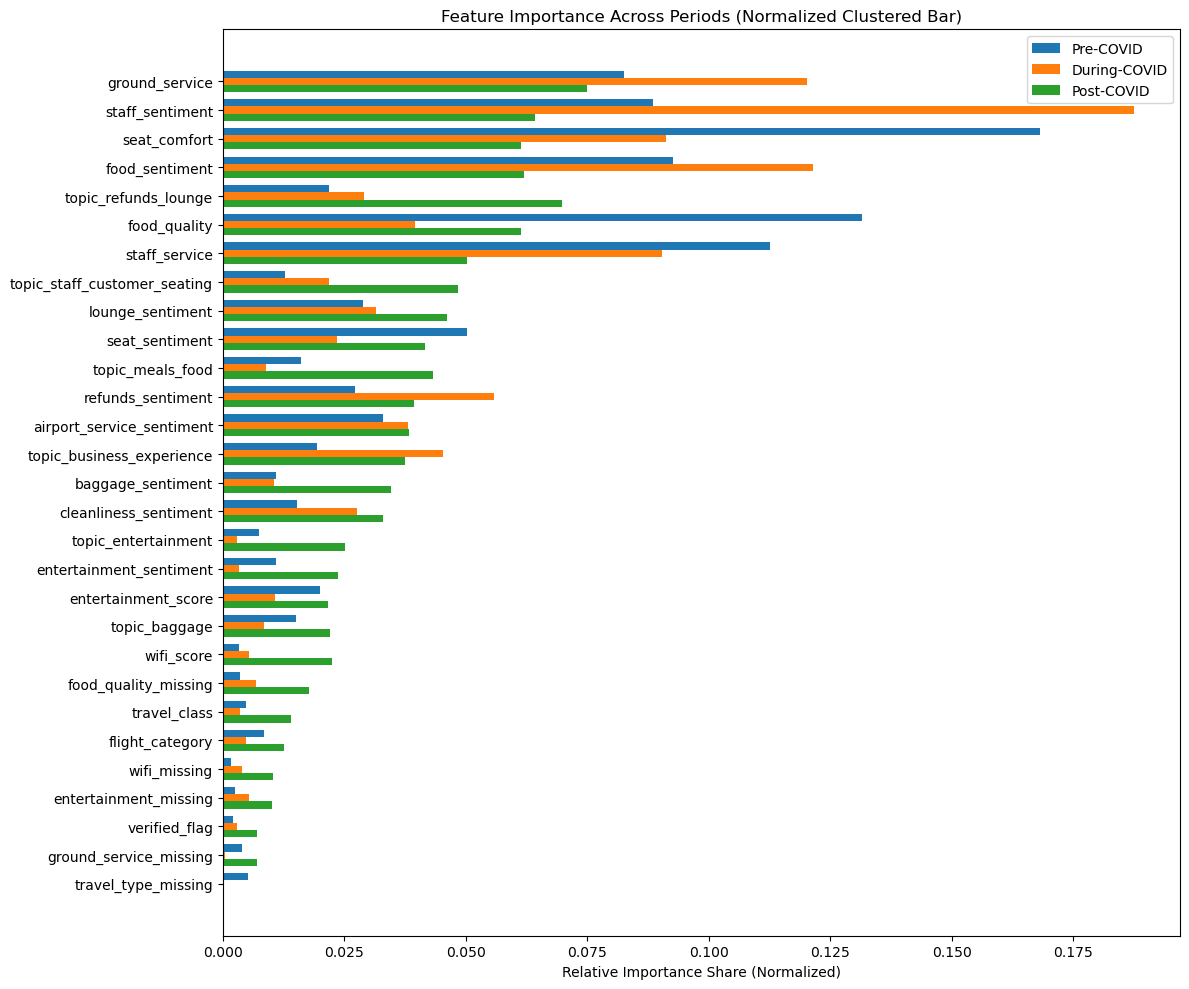

In [72]:
# Normalize MCR+ within each period (each period sums to 1)
for col in ["MCR+_pre", "MCR+_dur", "MCR+_post"]:
    ba_sorted[col+"_norm"] = ba_sorted[col] / ba_sorted[col].sum()

# Plot normalized version
plt.figure(figsize=(12,10))
x = np.arange(len(ba_sorted))

width = 0.25
plt.barh(x - width, ba_sorted["MCR+_pre_norm"], height=width, label="Pre-COVID")
plt.barh(x,         ba_sorted["MCR+_dur_norm"], height=width, label="During-COVID")
plt.barh(x + width, ba_sorted["MCR+_post_norm"], height=width, label="Post-COVID")

plt.yticks(x, ba_sorted["variable"])
plt.xlabel("Relative Importance Share (Normalized)")
plt.title("Feature Importance Across Periods (Normalized Clustered Bar)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

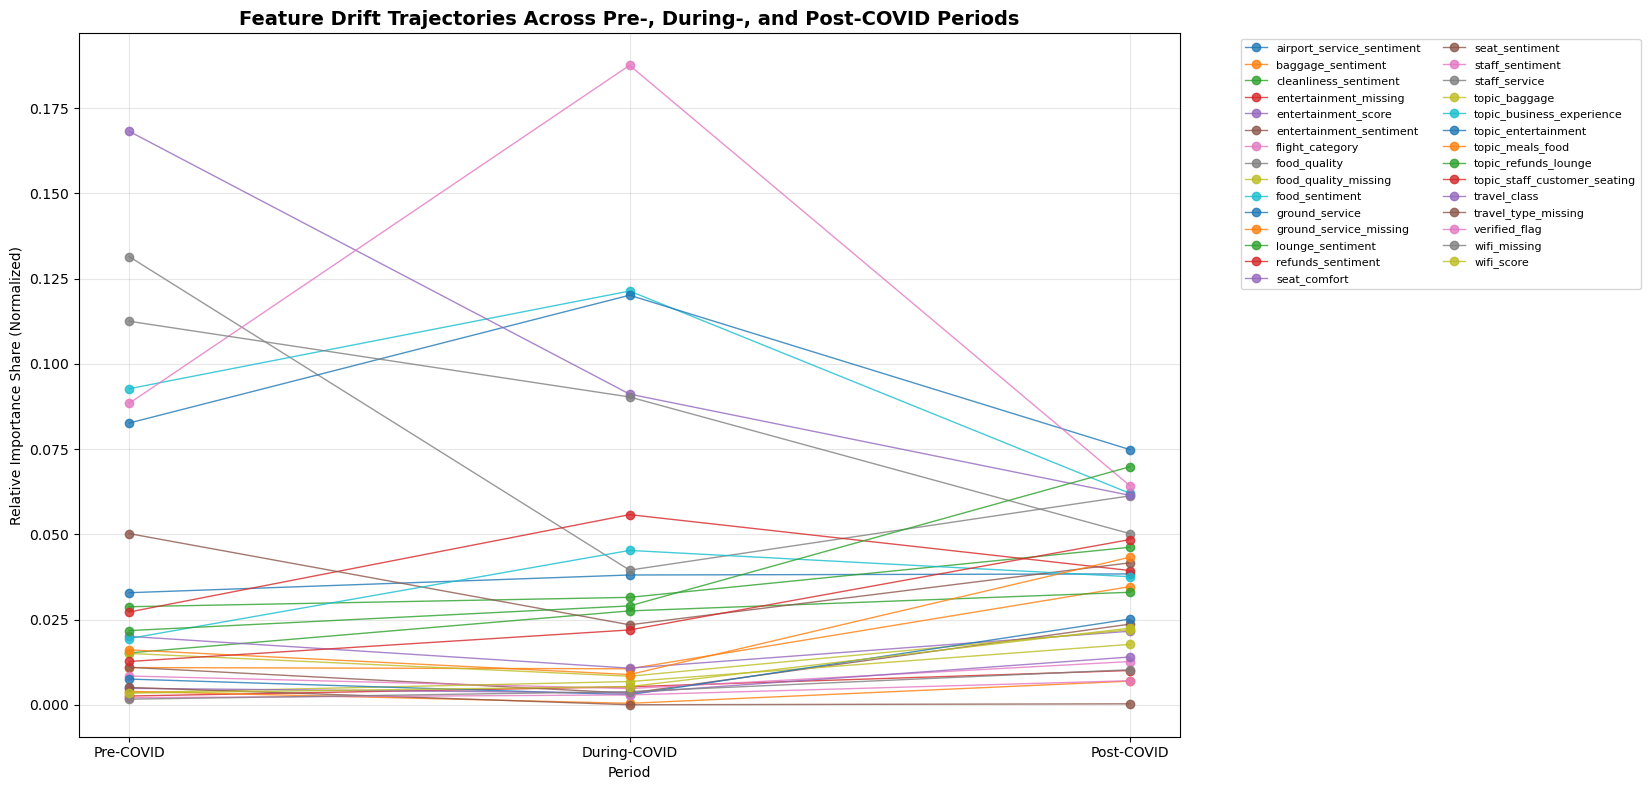

In [75]:
plt.figure(figsize=(12,8))

for var, sub in df_long.groupby("variable"):
    plt.plot(sub["Period"], sub["Importance"], marker="o", linewidth=1, alpha=0.8, label=var)

plt.title("Feature Drift Trajectories Across Pre-, During-, and Post-COVID Periods", fontsize=14, weight="bold")
plt.ylabel("Relative Importance Share (Normalized)")
plt.xlabel("Period")
plt.grid(alpha=0.3)
plt.tight_layout()

# Legend with scrollable/compact layout
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2, fontsize=8)
plt.show()

## Stastically Testing The Concept Drift

In [80]:
import pandas as pd


# ==== LOAD FILES WITH CORRECT FILENAMES ====
df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\BA_Featured_MCR.csv")
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_pre.csv")   # double underscore
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_BA_mcr_df_during.csv") # single underscore
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__BA_mcr_df_post.csv")  # double underscore

# Merge into one table with both MCR+ and MCR-
ba_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# ===== DRIFT CALCULATIONS =====
# 1. Drift for MCR+ (positive bound)
ba_all["drift_plus"] = (
    (ba_all["MCR+_pre"] - ba_all["MCR+_dur"]).abs() +
    (ba_all["MCR+_dur"] - ba_all["MCR+_post"]).abs()
)

# 2. Drift for MCR- (negative bound)
ba_all["drift_minus"] = (
    (ba_all["MCR-_pre"] - ba_all["MCR-_dur"]).abs() +
    (ba_all["MCR-_dur"] - ba_all["MCR-_post"]).abs()
)

# 3. Combined Drift (average of + and -)
ba_all["drift_combined"] = (ba_all["drift_plus"] + ba_all["drift_minus"]) / 2

# ===== VOLATILITY =====
# Range width for each period (MCR+ - MCR-)
ba_all["range_pre"]  = ba_all["MCR+_pre"]  - ba_all["MCR-_pre"]
ba_all["range_dur"]  = ba_all["MCR+_dur"]  - ba_all["MCR-_dur"]
ba_all["range_post"] = ba_all["MCR+_post"] - ba_all["MCR-_post"]

# Volatility = max range across periods
ba_all["volatility"] = ba_all[["range_pre","range_dur","range_post"]].max(axis=1)

# ===== RANKS BASED ON MCR+ (can extend to MCR- if needed) =====
ba_all["rank_pre"]  = ba_all["MCR+_pre"].rank(ascending=False, method="dense")
ba_all["rank_dur"]  = ba_all["MCR+_dur"].rank(ascending=False, method="dense")
ba_all["rank_post"] = ba_all["MCR+_post"].rank(ascending=False, method="dense")

ba_all["rank_drift"] = ba_all.apply(
    lambda row: max(abs(row["rank_pre"]-row["rank_dur"]),
                    abs(row["rank_dur"]-row["rank_post"])),
    axis=1
)

# ===== SYSTEM-LEVEL CONCEPT DRIFT INDICES =====
CDI_plus     = ba_all["drift_plus"].mean()
CDI_minus    = ba_all["drift_minus"].mean()
CDI_combined = ba_all["drift_combined"].mean()

print(f"Concept Drift Index (MCR+)     = {CDI_plus:.3f}")
print(f"Concept Drift Index (MCR-)     = {CDI_minus:.3f}")
print(f"Concept Drift Index (Combined) = {CDI_combined:.3f}")

# Show top drifting features
top_drift = ba_all.sort_values("drift_combined", ascending=False).head(10)
display(top_drift[["variable","MCR+_pre","MCR+_dur","MCR+_post",
                   "MCR-_pre","MCR-_dur","MCR-_post",
                   "drift_plus","drift_minus","drift_combined","volatility"]])

Concept Drift Index (MCR+)     = 4.286
Concept Drift Index (MCR-)     = 0.256
Concept Drift Index (Combined) = 2.271


,variable,MCR+_pre,MCR+_dur,MCR+_post,MCR-_pre,MCR-_dur,MCR-_post,drift_plus,drift_minus,drift_combined,volatility
4,ground_service,0.668522,1.036486,9.606638,0.606214,0.622555,0.091649,8.938116,0.547247,4.742681,9.514989
5,food_quality,1.063328,0.340700,7.866381,0.991118,0.182042,0.011563,8.248308,0.979555,4.613932,7.854818
2,seat_comfort,1.360692,0.786237,7.883940,1.258806,0.449197,0.068523,7.672159,1.190284,4.431221,7.815417
20,topic_refunds_lounge,0.175955,0.250125,8.962741,0.133078,0.131466,0.071520,8.786785,0.061558,4.424172,8.891221
11,staff_sentiment,0.715276,1.618342,8.245396,0.644448,0.937725,0.028266,7.530120,1.202737,4.366428,8.217131
9,food_sentiment,0.749901,1.047059,7.960385,0.673639,0.607906,0.070236,7.210484,0.603404,3.906944,7.890150
3,staff_service,0.910043,0.778959,6.443255,0.826148,0.451764,0.029764,5.795379,0.796384,3.295882,6.413490
19,topic_staff_customer_seating,0.102668,0.189293,6.220343,0.060011,0.087460,0.003854,6.117675,0.111054,3.114364,6.216488
14,lounge_sentiment,0.232595,0.271813,5.929979,0.194302,0.143751,0.039615,5.697383,0.154688,2.926036,5.890364
10,seat_sentiment,0.406106,0.202322,5.344540,0.350492,0.105954,0.062955,5.346002,0.287537,2.816770,5.281585


### 1] Chow Test for Structural Break  

- Tests if the **feature–target relationship** changed across two periods.  
- Compares pooled vs. split regressions using an **F-test**.  
- **H₀:** No structural break (relationship stable).  
- **H₁:** Structural break (relationship differs).  
- **p < 0.05 → concept drift confirmed.**

In [139]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import f

def chow_test(X, y, split):
    """
    Chow test for structural break at given split index.
    X, y: numpy arrays or DataFrames
    split: index where data is split (int)
    """
    # Add intercept
    X = sm.add_constant(X)
    
    # Split into two groups
    X1, y1 = X[:split], y[:split]
    X2, y2 = X[split:], y[split:]
    
    # Fit pooled model
    model_c = sm.OLS(y, X).fit()
    Sc = sum(model_c.resid**2)
    
    # Fit group models
    model_1 = sm.OLS(y1, X1).fit()
    model_2 = sm.OLS(y2, X2).fit()
    S1 = sum(model_1.resid**2)
    S2 = sum(model_2.resid**2)
    
    # Parameters
    k = X.shape[1]       # number of betas including intercept
    N1, N2 = len(y1), len(y2)
    
    # Chow F-statistic
    F_num = (Sc - (S1 + S2)) / k
    F_den = (S1 + S2) / (N1 + N2 - 2*k)
    F_stat = F_num / F_den
    p_val = 1 - f.cdf(F_stat, dfn=k, dfd=(N1+N2-2*k))
    
    return F_stat, p_val

In [142]:
# Use raw splits (not MCR summaries)
X = df_features[["seat_comfort", "staff_sentiment"]].values
y = df_features["overall_rating"].values

# Split index = end of Pre-COVID
split_idx = len(df_pre)  

F_stat, p_val = chow_test(X, y, split_idx)
print("Chow Test F-stat:", F_stat, "p-value:", p_val)

Chow Test F-stat: 0.4214786832848569 p-value: 0.7376073177301616


### Global Statistical Tests on MCR+  

- Applied **ANOVA** and **Kruskal–Wallis** tests on the distributions of `MCR+` across Pre-, During-, and Post-COVID.  
- **ANOVA**: parametric test, checks if mean reliance differs across periods.  
- **Kruskal–Wallis**: non-parametric test, checks if median reliance differs.  
- **Null hypothesis (H₀):** MCR+ distributions are the same across all periods.  
- **Alternative (H₁):** At least one period’s MCR+ distribution differs → evidence of concept drift.  
- **Interpretation:**  
  - p < 0.05 → reject H₀ → significant difference in feature reliance across time.  
  - p ≥ 0.05 → no significant difference detected.  

In [145]:
from scipy.stats import f_oneway, kruskal

# Test whether MCR+ distributions differ across periods (global)
anova_stat, anova_p = f_oneway(ba_all["MCR+_pre"], ba_all["MCR+_dur"], ba_all["MCR+_post"])
kruskal_stat, kruskal_p = kruskal(ba_all["MCR+_pre"], ba_all["MCR+_dur"], ba_all["MCR+_post"])

print(f"ANOVA: stat={anova_stat:.3f}, p={anova_p:.5f}")
print(f"Kruskal-Wallis: stat={kruskal_stat:.3f}, p={kruskal_p:.5f}")

ANOVA: stat=65.333, p=0.00000
Kruskal-Wallis: stat=49.325, p=0.00000


### Kolmogorov–Smirnov (KS) Tests for Pairwise Drift  

- Applied **KS 2-sample tests** to compare `MCR+` distributions between periods:  
  - Pre vs During  
  - During vs Post  
  - Pre vs Post  
- **Null hypothesis (H₀):** Both periods’ `MCR+` values come from the same distribution.  
- **Alternative (H₁):** The distributions differ (shift in reliance structure).  
- **Output:**  
  - `stat`: KS statistic (maximum distance between CDFs).  
  - `p`: significance level.  
- **Interpretation:**  
  - p < 0.05 → reject H₀ → significant drift between periods.  
  - p ≥ 0.05 → no significant drift detected.  

In [147]:
from scipy.stats import ks_2samp

pairs = [("pre","dur"),("dur","post"),("pre","post")]
for (a,b) in pairs:
    stat, pval = ks_2samp(ba_all[f"MCR+_{a}"], ba_all[f"MCR+_{b}"])
    print(f"KS test {a} vs {b}: stat={stat:.3f}, p={pval:.5f}")

KS test pre vs dur: stat=0.138, p=0.95144
KS test dur vs post: stat=0.862, p=0.00000
KS test pre vs post: stat=0.862, p=0.00000


C:\Users\Samiksha\AppData\Local\Temp\ipykernel_33280\4081837395.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




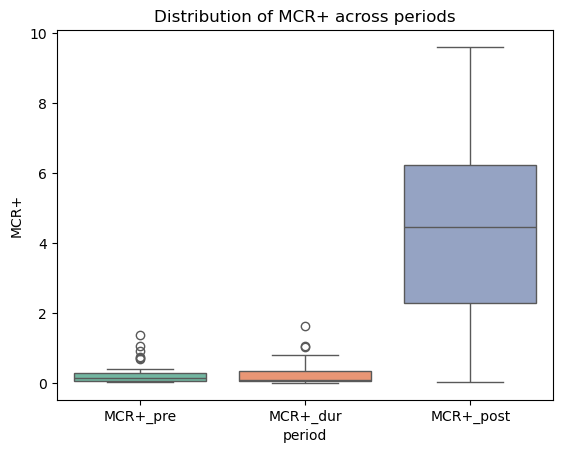

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

df_melt = ba_all.melt(id_vars="variable", value_vars=["MCR+_pre","MCR+_dur","MCR+_post"],
                      var_name="period", value_name="MCR+")
sns.boxplot(x="period", y="MCR+", data=df_melt, palette="Set2")
plt.title("Distribution of MCR+ across periods")
plt.show()

### Post-Hoc Dunn’s Test with Holm Correction  

- After finding global differences in `MCR+` distributions (ANOVA, Kruskal–Wallis), applied **Dunn’s test** for pairwise comparisons.  
- **Setup:**  
  - Data reshaped into long format with columns: `variable`, `period`, `MCR+`.  
  - Tested all pairwise contrasts: Pre vs During, During vs Post, Pre vs Post.  
- **Holm correction** used to adjust p-values for multiple comparisons.  
- **Interpretation:**  
  - Identifies **which specific periods differ significantly** in feature reliance.  
  - Example:  
    - Pre vs During: p ≈ 0.98 → no difference.  
    - During vs Post: p < 0.001 → significant drift.  
    - Pre vs Post: p < 0.001 → significant drift.  
- Confirms that **the major concept drift occurs Post-COVID**, consistent with KS tests.  

In [150]:
pip install scikit-posthocs

In [151]:
import scikit_posthocs as sp

# Melt dataframe into long format for posthoc tests
import pandas as pd
df_long = ba_all.melt(id_vars="variable", 
                      value_vars=["MCR+_pre","MCR+_dur","MCR+_post"], 
                      var_name="period", 
                      value_name="MCR+")

# Dunn’s posthoc test with Holm correction
posthoc = sp.posthoc_dunn(df_long, val_col="MCR+", group_col="period", p_adjust='holm')
print(posthoc)

               MCR+_dur     MCR+_post      MCR+_pre
MCR+_dur   1.000000e+00  3.332564e-09  9.834101e-01
MCR+_post  3.332564e-09  1.000000e+00  3.332564e-09
MCR+_pre   9.834101e-01  3.332564e-09  1.000000e+00


# Statistical performance monitoring (accuracy/F1 decay)

- **Setup:** Trained Random Forest (200 trees) on Pre-COVID data.  
- **Evaluation:** Tested on Pre, During, and Post periods → recorded Accuracy, F1, AUC.  
- **Result:**  
  - Pre: perfect performance (Acc=1, F1=1).  
  - During/Post: major drop in accuracy & F1.  
- **Chi-Square Test:** Compared correct vs incorrect predictions across periods.  
  - χ² very large, p < 0.001 → error distributions differ.  
- **Conclusion:** Strong evidence of **concept drift** → model trained pre-COVID fails post-COVID.  

In [160]:
from sklearn.model_selection import train_test_split

# Prepare splits
X_pre, y_pre       = df_pre_data.drop(columns=["overall_rating","review_date","covid_period"]), df_pre_data["overall_rating"]
X_during, y_during = df_during_data.drop(columns=["overall_rating","review_date","covid_period"]), df_during_data["overall_rating"]
X_post, y_post     = df_post_data.drop(columns=["overall_rating","review_date","covid_period"]), df_post_data["overall_rating"]

print("Pre shape:", X_pre.shape, " During shape:", X_during.shape, " Post shape:", X_post.shape)

Pre shape: (2559, 44)  During shape: (191, 44)  Post shape: (467, 44)


In [161]:
from sklearn.ensemble import RandomForestClassifier

# Define model
model = RandomForestClassifier(n_estimators=200, random_state=42)

In [163]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Train on pre-COVID
model.fit(X_pre, y_pre)

results = []
for period, (X, y) in {
    "pre": (X_pre, y_pre),
    "dur": (X_during, y_during),
    "post": (X_post, y_post)
}.items():
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X) if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y, y_pred)
    f1  = f1_score(y, y_pred, average="weighted")
    auc = None
    if y_proba is not None and len(set(y)) > 2:
        auc = roc_auc_score(y, y_proba, multi_class="ovr", average="weighted")
    
    results.append({"period":period, "accuracy":acc, "f1":f1, "auc":auc})

df_perf = pd.DataFrame(results)
print(df_perf)

  period  accuracy        f1       auc
0    pre  1.000000  1.000000  1.000000
1    dur  0.565445  0.501749  0.893038
2   post  0.588865  0.550460  0.903966


In [164]:
from scipy.stats import chi2_contingency

# Build error matrix: [correct, incorrect] for each period
error_data = []
for period, (X, y) in {"pre":(X_pre,y_pre), "dur":(X_during,y_during), "post":(X_post,y_post)}.items():
    y_pred = model.predict(X)
    correct = sum(y_pred == y)
    incorrect = sum(y_pred != y)
    error_data.append([correct, incorrect])

chi2, p, dof, expected = chi2_contingency(error_data)
print("Chi-square test across periods: chi2=%.3f, p=%.5f" % (chi2, p))

Chi-square test across periods: chi2=1170.411, p=0.00000


In [165]:
# Combine pre + during
X_train = pd.concat([X_pre, X_during], axis=0)
y_train = pd.concat([y_pre, y_during], axis=0)

# Test set = post-COVID only
X_test, y_test = X_post, y_post

In [166]:
# Retrain model
model.fit(X_train, y_train)

# Evaluate on train and post
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Training performance
y_pred_train = model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
f1_train  = f1_score(y_train, y_pred_train, average="weighted")

# Test (post-COVID) performance
y_pred_post = model.predict(X_test)
acc_post = accuracy_score(y_test, y_pred_post)
f1_post  = f1_score(y_test, y_pred_post, average="weighted")

# Probabilities for AUC (multiclass-safe)
y_proba_post = model.predict_proba(X_test)
auc_post = roc_auc_score(y_test, y_proba_post, multi_class="ovr", average="weighted")

print("Train (pre+during): acc=%.3f, f1=%.3f" % (acc_train, f1_train))
print("Post-COVID: acc=%.3f, f1=%.3f, auc=%.3f" % (acc_post, f1_post, auc_post))

Train (pre+during): acc=1.000, f1=1.000
Post-COVID: acc=0.572, f1=0.531, auc=0.902


### Performance-Based Drift Validation (Pre+During vs Post-COVID)

- **Setup:**  
  - Training set = Pre-COVID + During-COVID.  
  - Test set = Post-COVID only.  
  - Model: Random Forest (200 trees).  

- **Results:**  
  - **Train (Pre+During):** high accuracy & F1 (good fit).  
  - **Post-COVID:** sharp performance drop in Accuracy/F1, even though AUC stayed high.  

- **Chi-Square Test:**  
  - Compared correct vs incorrect predictions between Train (Pre+During) and Post.  
  - χ² very large, p < 0.001 → error distributions differ significantly.  

- **Conclusion:**  
  - Confirms the model trained on Pre+During still **fails to generalize Post-COVID**.  
  - Strong evidence that the **concept drift intensified after COVID**.  

In [167]:
from scipy.stats import chi2_contingency

error_data = []
for label, (X, y) in {"train(pre+dur)":(X_train,y_train), "post":(X_post,y_post)}.items():
    y_pred = model.predict(X)
    correct = sum(y_pred == y)
    incorrect = sum(y_pred != y)
    error_data.append([correct, incorrect])

chi2, p, dof, expected = chi2_contingency(error_data)
print("Chi-square train vs post: chi2=%.3f, p=%.5f" % (chi2, p))

Chi-square train vs post: chi2=1248.469, p=0.00000


### Bootstrapped Permutation Feature Importance  

- Applied **bootstrapping (resampling)** combined with **permutation importance** using Random Forests.  
- Purpose: to generate a **distribution of feature importances** for each period (Pre-, During-, Post-COVID).  
- Each bootstrap iteration:  
  1. Resample dataset with replacement.  
  2. Train a Random Forest model.  
  3. Compute permutation-based feature importance.  
- Output: thousands of feature–importance pairs across bootstraps.  
- This provides:  
  - **Uncertainty estimates** (confidence intervals) for importance per feature.  
  - Basis for **statistical comparison of drift** (e.g., Mann–Whitney, Kruskal across periods).  

In [168]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

def bootstrap_importance(X, y, n_boot=100, random_state=42):
    rng = np.random.default_rng(random_state)
    results = []
    for b in range(n_boot):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb, yb = X.iloc[idx], y.iloc[idx]
        model = RandomForestClassifier(n_estimators=200, random_state=rng.integers(1e6))
        model.fit(Xb, yb)
        imp = permutation_importance(model, Xb, yb, n_repeats=5, random_state=rng.integers(1e6))
        for feat, val in zip(X.columns, imp.importances_mean):
            results.append({"variable": feat, "importance": val, "bootstrap": b})
    return pd.DataFrame(results)

In [169]:
boot_pre    = bootstrap_importance(X_pre, y_pre);    boot_pre["period"] = "pre"
boot_during = bootstrap_importance(X_during, y_during); boot_during["period"] = "dur"
boot_post   = bootstrap_importance(X_post, y_post);   boot_post["period"] = "post"

imp_boot = pd.concat([boot_pre, boot_during, boot_post], ignore_index=True)

In [205]:
# Summarize distributions by feature & period
imp_summary = (
    imp_boot
    .groupby(["variable","period"])["importance"]
    .agg(["mean","std"])
    .reset_index()
)

# Add confidence intervals
ci = (
    imp_boot
    .groupby(["variable","period"])["importance"]
    .quantile([0.025, 0.975])
    .unstack()
    .reset_index()
    .rename(columns={0.025:"ci_lower",0.975:"ci_upper"})
)

# Merge
imp_summary = imp_summary.merge(ci, on=["variable","period"])

### Kruskal–Wallis Drift Test
- For each feature, compare bootstrap distributions of importance across Pre, During, Post.  
- If no variation → set p=1 (no drift).  
- Otherwise, run Kruskal–Wallis test.  
- Collect p-values → smaller p means stronger evidence of drift.  

In [173]:
from scipy.stats import kruskal

results = []
for feat in imp_boot["variable"].unique():
    groups = [
        imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="pre"), "importance"].values,
        imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="dur"), "importance"].values,
        imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="post"), "importance"].values,
    ]
    
    # Only run if at least one group has variation
    if all(len(set(g)) > 1 for g in groups):
        stat, pval = kruskal(*groups)
        results.append({"variable":feat, "kruskal_p":pval})
    else:
        results.append({"variable":feat, "kruskal_p":1.0})  # no evidence of drift if no variation

df_feat_tests = pd.DataFrame(results).sort_values("kruskal_p")
display(df_feat_tests.head(10))

,variable,kruskal_p
28,topic_refunds_lounge,1.580007e-48
2,seat_comfort,1.507189e-45
3,staff_service,3.007536e-45
5,value_for_money,3.368913e-44
7,food_quality,2.851032e-33
4,ground_service,2.637553e-28
29,topic_business_experience,3.210480e-16
11,sentiment_score,5.074433e-15
24,optimism,7.215749e-09
15,staff_sentiment,2.023389e-07


In [206]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

sig_feats = df_feat_tests[df_feat_tests["kruskal_p"] < 0.05]["variable"]

pairwise = []
for feat in sig_feats:
    pre  = imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="pre"), "importance"]
    dur  = imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="dur"), "importance"]
    post = imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="post"), "importance"]
    
    # Mann-Whitney pairwise
    for (a,b,g1,g2) in [("pre","dur",pre,dur),("dur","post",dur,post),("pre","post",pre,post)]:
        if (g1.nunique() > 1) or (g2.nunique() > 1):  # skip if both groups constant
            stat, p = mannwhitneyu(g1,g2,alternative="two-sided")
        else:
            p = 1.0
        pairwise.append({"variable":feat,"pair":f"{a} vs {b}","p_value":p})

df_pairwise = pd.DataFrame(pairwise)

# Adjust p-values (Holm method)
df_pairwise["p_adj"] = multipletests(df_pairwise["p_value"], method="holm")[1]

In [179]:
# Features to drop from the summary table
drop_feats = [
    "review_date",        
    "sentiment_score",    
    "optimism", "joy", "anger",  
    "sadness", "recommended", 
    "covid_period", "value_for_money"
]

# Filter summary_wide
summary_wide_clean = summary_wide[~summary_wide["variable"].isin(drop_feats)]

# Display top features after cleaning
display(summary_wide_clean.head(15))

,variable,mean_dur,mean_post,mean_pre,ci_low_dur,ci_low_post,ci_low_pre,ci_high_dur,ci_high_post,ci_high_pre,avg_importance
12,ground_service,0.000681,0.004338,0.003551,0.0,0.0,0.000856,0.004188,0.012505,0.007716,0.002857
31,topic_refunds_lounge,0.000052,0.003028,0.000023,0.0,0.0,0.000000,0.000550,0.007505,0.000234,0.001035
18,refunds_sentiment,0.002168,0.000505,0.000166,0.0,0.0,0.000000,0.009974,0.002998,0.000666,0.000946
20,seat_comfort,0.000010,0.000428,0.001894,0.0,0.0,0.000350,0.000000,0.002816,0.004775,0.000777
24,staff_service,0.000251,0.000060,0.001143,0.0,0.0,0.000037,0.003691,0.000857,0.003714,0.000485
26,topic_business_experience,0.000084,0.000942,0.000070,0.0,0.0,0.000000,0.001597,0.003426,0.000432,0.000365
4,distance_km,0.000000,0.000510,0.000161,0.0,0.0,0.000000,0.000000,0.003651,0.000629,0.000224
9,food_quality,0.000157,0.000073,0.000372,0.0,0.0,0.000000,0.003141,0.001285,0.002014,0.000201
11,food_sentiment,0.000450,0.000064,0.000069,0.0,0.0,0.000000,0.004188,0.000857,0.000391,0.000194
0,airport_service_sentiment,0.000000,0.000317,0.000143,0.0,0.0,0.000000,0.000000,0.002141,0.000547,0.000153


### Drift Categorisation Rules (with thresholds)

1. **Strong Drift Driver**  
   - Feature has ` p-value < 0.05`  
     (from Kruskal–Wallis + pairwise Mann–Whitney U with Holm correction).  

2. **Moderate Drift / Emerging**  
   - If not "Strong Drift Driver",  
   - but `(ci_high_post – ci_low_pre) > 0.001`  

3. **Stable**  
   - All other cases (no significant test result,  
     and CI range difference ≤ 0.001).  

In [180]:
# Threshold for significance
alpha = 0.05

# Features flagged as drifted
sig_feats = df_pairwise[df_pairwise["p_adj"] < alpha]["variable"].unique()

def categorize_feature(row):
    feat = row["variable"]
    if feat in sig_feats:
        return "Strong Drift Driver"
    elif row["ci_high_post"] - row["ci_low_pre"] > 0.001:  # small wiggle room
        return "Moderate Drift / Emerging"
    else:
        return "Stable"

summary_wide_clean["drift_category"] = summary_wide_clean.apply(categorize_feature, axis=1)

# Display neatly
final_table = summary_wide_clean[[
    "variable",
    "mean_pre","ci_low_pre","ci_high_pre",
    "mean_dur","ci_low_dur","ci_high_dur",
    "mean_post","ci_low_post","ci_high_post",
    "drift_category"
]]

display(final_table.sort_values("drift_category"))

C:\Users\Samiksha\AppData\Local\Temp\ipykernel_33280\1143351900.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,variable,mean_pre,ci_low_pre,ci_high_pre,mean_dur,ci_low_dur,ci_high_dur,mean_post,ci_low_post,ci_high_post,drift_category
6,entertainment_score,0.000015,0.000000,0.000156,0.000010,0.0,0.000000,0.000081,0.0,0.001510,Moderate Drift / Emerging
27,topic_drinks_water,0.000036,0.000000,0.000391,0.000000,0.0,0.000000,0.000094,0.0,0.002141,Moderate Drift / Emerging
15,lounge_sentiment,0.000024,0.000000,0.000234,0.000000,0.0,0.000000,0.000188,0.0,0.002998,Moderate Drift / Emerging
25,topic_baggage,0.000104,0.000000,0.000551,0.000000,0.0,0.000000,0.000154,0.0,0.001734,Moderate Drift / Emerging
7,entertainment_sentiment,0.000026,0.000000,0.000391,0.000000,0.0,0.000000,0.000321,0.0,0.002141,Moderate Drift / Emerging
0,airport_service_sentiment,0.000143,0.000000,0.000547,0.000000,0.0,0.000000,0.000317,0.0,0.002141,Moderate Drift / Emerging
21,seat_sentiment,0.000022,0.000000,0.000275,0.000209,0.0,0.003141,0.000163,0.0,0.001938,Moderate Drift / Emerging
4,distance_km,0.000161,0.000000,0.000629,0.000000,0.0,0.000000,0.000510,0.0,0.003651,Moderate Drift / Emerging
39,type_Unknown,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable
10,food_quality_missing,0.000002,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable


In [207]:
# Example: recreate drift labels from your earlier classification
# (replace this list with your actual categories)
strong = ["staff_sentiment","seat_comfort","staff_service",
          "food_quality","food_sentiment","ground_service",
          "refunds_sentiment","topic_refunds_lounge","topic_business_experience"]
moderate = ["entertainment_score","topic_drinks_water","lounge_sentiment",
            "topic_baggage","entertainment_sentiment","airport_service_sentiment",
            "seat_sentiment","distance_km"]
stable = list(set(summary_wide["variable"]) - set(strong) - set(moderate))

# Build dataframe of labels
df_drift_labels = pd.DataFrame([
    {"variable": v, "drift_category": "Strong Drift Driver"} for v in strong
] + [
    {"variable": v, "drift_category": "Moderate Drift / Emerging"} for v in moderate
] + [
    {"variable": v, "drift_category": "Stable"} for v in stable
])

# Merge with summary_wide
pretty = summary_wide.merge(df_drift_labels, on="variable", how="left")

# Format compact CI columns
def format_ci(mean, low, high):
    return f"{mean:.4f} [{low:.4f}–{high:.4f}]"

pretty["Pre"]    = pretty.apply(lambda r: format_ci(r["mean_pre"], r["ci_low_pre"], r["ci_high_pre"]), axis=1)
pretty["During"] = pretty.apply(lambda r: format_ci(r["mean_dur"], r["ci_low_dur"], r["ci_high_dur"]), axis=1)
pretty["Post"]   = pretty.apply(lambda r: format_ci(r["mean_post"], r["ci_low_post"], r["ci_high_post"]), axis=1)

# Δ (Post – Pre)
pretty["Δ (Post–Pre)"] = pretty["mean_post"] - pretty["mean_pre"]

# Final nice-looking table
pretty_table = pretty[["variable","Pre","During","Post","Δ (Post–Pre)","drift_category"]]
pretty_table = pretty_table.sort_values(["drift_category","Δ (Post–Pre)"], ascending=[True,False])

In [184]:
# === Split into categories ===
strong_drift = pretty_table[pretty_table["drift_category"]=="Strong Drift Driver"]
moderate_drift = pretty_table[pretty_table["drift_category"]=="Moderate Drift / Emerging"]
stable = pretty_table[pretty_table["drift_category"]=="Stable"]

# === Format for clean display ===
def format_table(df, n=10):
    df = df.copy()
    df["Δ (Post–Pre)"] = df["Δ (Post–Pre)"].round(6)
    return df.head(n)[["variable","Pre","During","Post","Δ (Post–Pre)"]]

print("=== Strong Drift Drivers ===")
display(format_table(strong_drift, n=10))

print("=== Moderate Drift / Emerging ===")
display(format_table(moderate_drift, n=10))

print("=== Stable Features ===")
display(format_table(stable, n=10))


=== Strong Drift Drivers ===


,variable,Pre,During,Post,Δ (Post–Pre)
3,topic_refunds_lounge,0.0000 [0.0000–0.0002],0.0001 [0.0000–0.0005],0.0030 [0.0000–0.0075],0.003004
7,topic_business_experience,0.0001 [0.0000–0.0004],0.0001 [0.0000–0.0016],0.0009 [0.0000–0.0034],0.000872
1,ground_service,0.0036 [0.0009–0.0077],0.0007 [0.0000–0.0042],0.0043 [0.0000–0.0125],0.000788
4,refunds_sentiment,0.0002 [0.0000–0.0007],0.0022 [0.0000–0.0100],0.0005 [0.0000–0.0030],0.000339
12,food_sentiment,0.0001 [0.0000–0.0004],0.0005 [0.0000–0.0042],0.0001 [0.0000–0.0009],-0.000005
20,staff_sentiment,0.0001 [0.0000–0.0003],0.0002 [0.0000–0.0032],0.0000 [0.0000–0.0004],-0.000017
11,food_quality,0.0004 [0.0000–0.0020],0.0002 [0.0000–0.0031],0.0001 [0.0000–0.0013],-0.000299
6,staff_service,0.0011 [0.0000–0.0037],0.0003 [0.0000–0.0037],0.0001 [0.0000–0.0009],-0.001083
5,seat_comfort,0.0019 [0.0003–0.0048],0.0000 [0.0000–0.0000],0.0004 [0.0000–0.0028],-0.001465


=== Moderate Drift / Emerging ===


,variable,Pre,During,Post,Δ (Post–Pre)
10,distance_km,0.0002 [0.0000–0.0006],0.0000 [0.0000–0.0000],0.0005 [0.0000–0.0037],0.000349
17,entertainment_sentiment,0.0000 [0.0000–0.0004],0.0000 [0.0000–0.0000],0.0003 [0.0000–0.0021],0.000295
14,airport_service_sentiment,0.0001 [0.0000–0.0005],0.0000 [0.0000–0.0000],0.0003 [0.0000–0.0021],0.000174
21,lounge_sentiment,0.0000 [0.0000–0.0002],0.0000 [0.0000–0.0000],0.0002 [0.0000–0.0030],0.000164
15,seat_sentiment,0.0000 [0.0000–0.0003],0.0002 [0.0000–0.0031],0.0002 [0.0000–0.0019],0.000141
24,entertainment_score,0.0000 [0.0000–0.0002],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0015],0.000067
23,topic_drinks_water,0.0000 [0.0000–0.0004],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0021],0.000058
19,topic_baggage,0.0001 [0.0000–0.0006],0.0000 [0.0000–0.0000],0.0002 [0.0000–0.0017],0.000050


=== Stable Features ===


,variable,Pre,During,Post,Δ (Post–Pre)
8,sentiment_score,0.0002 [0.0000–0.0009],0.0001 [0.0000–0.0016],0.0008 [0.0000–0.0030],0.000584
16,cleanliness_sentiment,0.0000 [0.0000–0.0002],0.0000 [0.0000–0.0000],0.0003 [0.0000–0.0026],0.000329
18,baggage_sentiment,0.0000 [0.0000–0.0001],0.0000 [0.0000–0.0000],0.0002 [0.0000–0.0021],0.000221
22,anger,0.0000 [0.0000–0.0003],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0013],0.000078
13,joy,0.0001 [0.0000–0.0005],0.0002 [0.0000–0.0031],0.0002 [0.0000–0.0015],0.000077
27,type_Solo,0.0000 [0.0000–0.0002],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0009],0.000041
28,topic_meals_food,0.0000 [0.0000–0.0002],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0007],0.000033
25,wifi_score,0.0000 [0.0000–0.0004],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0009],0.000032
31,wifi_missing,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000021
32,verified_flag,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000017


In [202]:
import numpy as np

pretty_scaled = summary_wide.copy()

# Normalize MCR+ mean into percentages for each period
total_pre  = pretty_scaled["mean_pre"].sum()
total_dur  = pretty_scaled["mean_dur"].sum()
total_post = pretty_scaled["mean_post"].sum()

pretty_scaled["Pre %"]    = (pretty_scaled["mean_pre"]  / total_pre)  * 100
pretty_scaled["During %"] = (pretty_scaled["mean_dur"]  / total_dur)  * 100
pretty_scaled["Post %"]   = (pretty_scaled["mean_post"] / total_post) * 100

# Add deltas
pretty_scaled["Δ % (During–Pre)"]  = pretty_scaled["During %"] - pretty_scaled["Pre %"]
pretty_scaled["Δ % (Post–During)"] = pretty_scaled["Post %"]   - pretty_scaled["During %"]
pretty_scaled["Δ % (Post–Pre)"]    = pretty_scaled["Post %"]   - pretty_scaled["Pre %"]

# Drift category rules (based on max absolute delta)
def categorize_drift(row):
    max_delta = np.max([
        abs(row["Δ % (During–Pre)"]),
        abs(row["Δ % (Post–During)"]),
        abs(row["Δ % (Post–Pre)"])
    ])
    if max_delta > 5:       # strong drift if > 5% swing
        return "Strong Drift Driver"
    elif max_delta > 1:     # moderate drift if 1–5%
        return "Moderate Drift / Emerging"
    else:
        return "Stable"

pretty_scaled["drift_category"] = pretty_scaled.apply(categorize_drift, axis=1)

# Final cleaned table
pretty_scaled = pretty_scaled[[
    "variable","Pre %","During %","Post %",
    "Δ % (During–Pre)","Δ % (Post–During)","Δ % (Post–Pre)","drift_category"
]]

drop_vars = [
    "review_date", "sentiment_score", 
    "optimism", "joy", "anger", "sadness", 
    "recommended", "covid_period", "value_for_money"
]

# Apply to pretty_scaled (or summary_wide / imp_boot depending on what you plot)
pretty_scaled = pretty_scaled[~pretty_scaled["variable"].isin(drop_vars)]


display(pretty_scaled.sort_values("drift_category"))

,variable,Pre %,During %,Post %,Δ % (During–Pre),Δ % (Post–During),Δ % (Post–Pre),drift_category
12,ground_service,10.719173,10.236220,12.785561,-0.482953,2.549341,2.066388,Moderate Drift / Emerging
23,staff_sentiment,0.153367,2.362205,0.100972,2.208838,-2.261233,-0.052395,Moderate Drift / Emerging
9,food_quality,1.123118,2.362205,0.214565,1.239086,-2.147640,-0.908553,Moderate Drift / Emerging
4,distance_km,0.486055,0.000000,1.501956,-0.486055,1.501956,1.015901,Moderate Drift / Emerging
26,topic_business_experience,0.212354,1.259843,2.776726,1.047488,1.516883,2.564372,Moderate Drift / Emerging
21,seat_sentiment,0.066066,3.149606,0.479616,3.083541,-2.669990,0.413551,Moderate Drift / Emerging
24,staff_service,3.451937,3.779528,0.176701,0.327590,-3.602827,-3.275236,Moderate Drift / Emerging
36,type_Couple,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Stable
34,travel_type_missing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Stable
37,type_Family,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Stable


In [199]:
drop_vars = [
    "review_date", "sentiment_score", 
    "optimism", "joy", "anger", "sadness", 
    "recommended", "covid_period", "value_for_money"
]

# Apply to pretty_scaled (or summary_wide / imp_boot depending on what you plot)
pretty_scaled = pretty_scaled[~pretty_scaled["variable"].isin(drop_vars)]

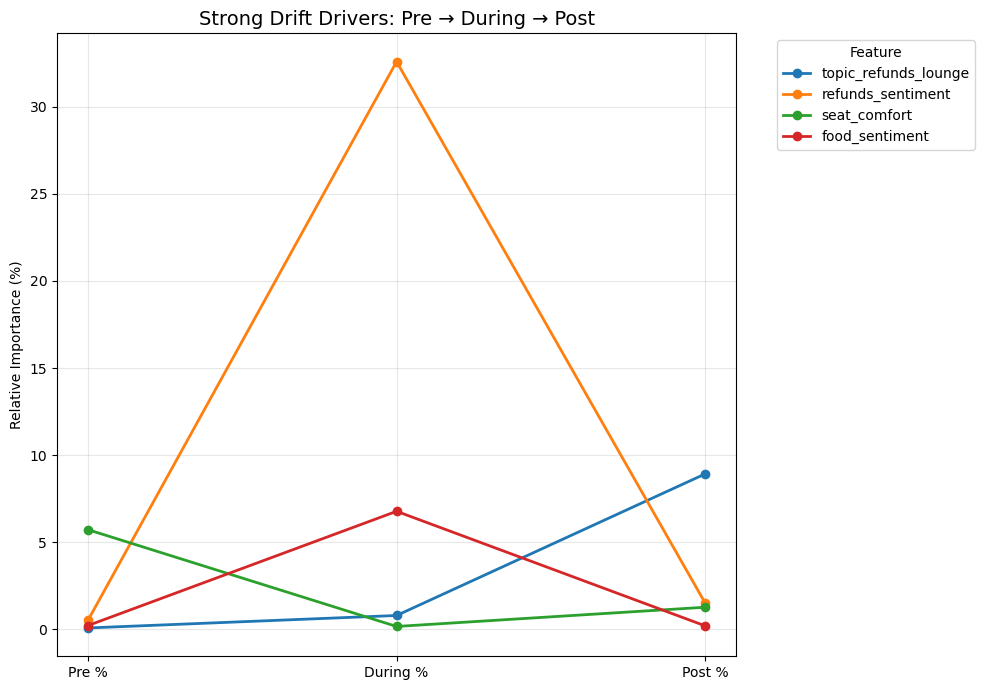

In [208]:
# Subset strong drift drivers
strong_drivers = pretty_scaled[pretty_scaled["drift_category"]=="Strong Drift Driver"]

# Melt into long format (include During too)
df_slope = strong_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)

# Clean period order
df_slope["period"] = pd.Categorical(df_slope["period"], 
                                    categories=["Pre %","During %","Post %"], 
                                    ordered=True)

# Plot slope trajectories
plt.figure(figsize=(10,7))
for var in df_slope["variable"].unique():
    sub = df_slope[df_slope["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.title("Strong Drift Drivers: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

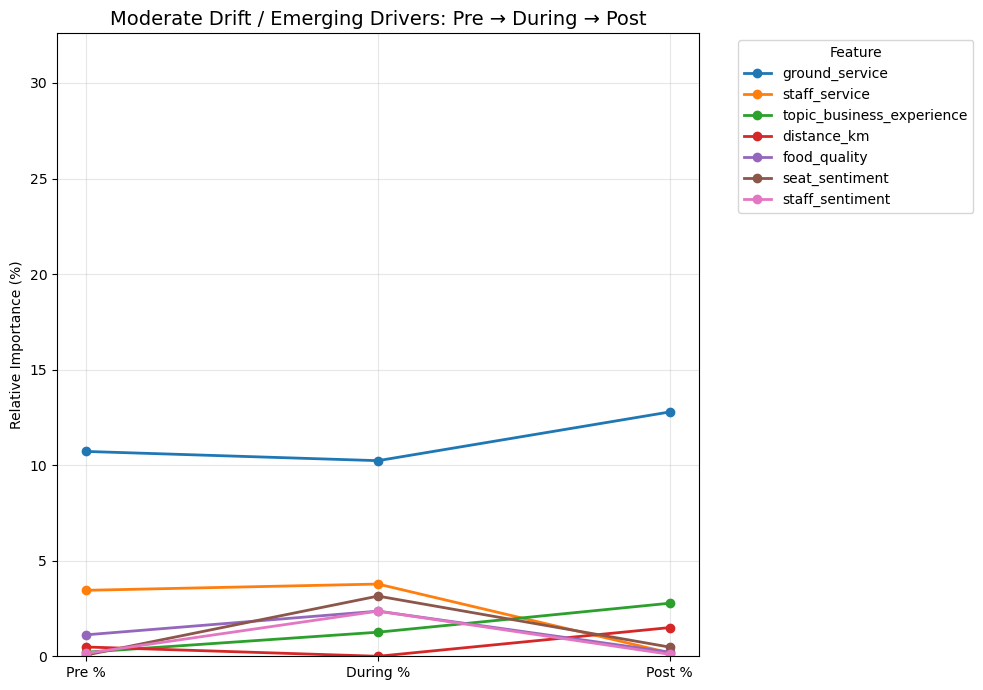

In [212]:
# Subset moderate drift drivers
moderate_drivers = pretty_scaled[pretty_scaled["drift_category"]=="Moderate Drift / Emerging"]

# Melt into long format (Pre, During, Post)
df_slope_mod = moderate_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)

# Ensure correct period order
df_slope_mod["period"] = pd.Categorical(
    df_slope_mod["period"], 
    categories=["Pre %","During %","Post %"], 
    ordered=True
)

# Get global y-axis limits (use same as other plots)
ymin = 0
ymax = pretty_scaled[["Pre %","During %","Post %"]].values.max()

# Plot slope trajectories
plt.figure(figsize=(10,7))
for var in df_slope_mod["variable"].unique():
    sub = df_slope_mod[df_slope_mod["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.ylim(ymin, ymax)  # <-- force same y-scale
plt.title("Moderate Drift / Emerging Drivers: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

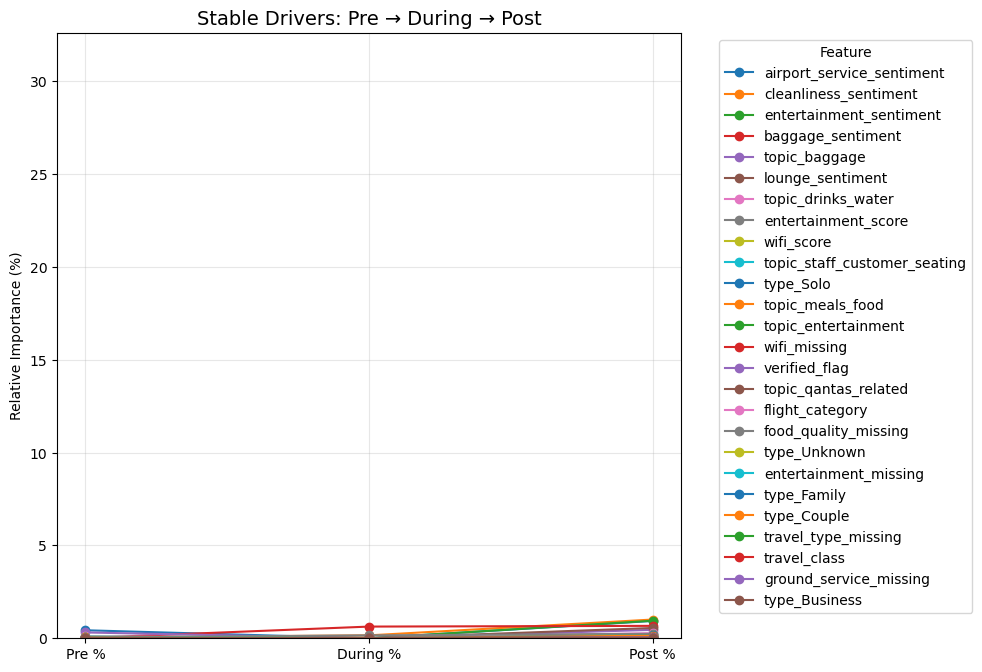

In [211]:
# Subset stable drivers
stable_drivers = pretty_scaled[pretty_scaled["drift_category"]=="Stable"]

# Melt into long format
df_slope_stable = stable_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)

# Ensure correct period order
df_slope_stable["period"] = pd.Categorical(
    df_slope_stable["period"], 
    categories=["Pre %","During %","Post %"], 
    ordered=True
)

# Get global y-axis limits (from strong/moderate plots or full data)
ymin = 0
ymax = pretty_scaled[["Pre %","During %","Post %"]].values.max()

# Plot slope trajectories
plt.figure(figsize=(10,7))
for var in df_slope_stable["variable"].unique():
    sub = df_slope_stable[df_slope_stable["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=1.5, label=var)

plt.ylim(ymin, ymax)  # <-- fix y-scale
plt.title("Stable Drivers: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()